In [342]:
import numpy as np
import scipy.signal as sig
import soundfile as sf
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter

In [343]:
def generate_impulse_train(F0, fs, duration):
    # generates an impulse train
    N = int(fs * duration)
    signal = np.zeros(N)
    phase = 0.0
    for n in range(N):
        phase += F0 / fs
        if phase >= 1.0:
            signal[n] = 1.0
            phase -= 1.0
    return signal

In [344]:
# --- Formant Resonator ---
# y[n] = A*x[n-1] + B*y[n-1] + C*y[n-2]
# with A = 1 – B – C, B = 2 exp(–π F_B T_s) cos(2π F T_s), C = -exp(–2π F_B T_s)
def formant_resonator(signal, formant_frequency, sample_rate, bandwidth):
    T_s = 1 / sample_rate
    B_coef = 2 * np.exp(-np.pi * bandwidth * T_s) * np.cos(2 * np.pi * formant_frequency * T_s)
    C_coef = -1*np.exp(-2 * np.pi * bandwidth * T_s)
    A_coef = 1 - B_coef - C_coef
    y = np.zeros_like(signal)
    # For n = 0, no previous input; set y[0] = 0.
    y[0] = 0
    # For n = 1, use x[0]
    if len(signal) > 1:
        y[1] = A_coef * signal[0] + B_coef * y[0]
    # For n >= 2, follow the difference equation.
    for n in range(2, len(signal)):
        y[n] = A_coef * signal[n-1] + B_coef * y[n-1] + C_coef * y[n-2]
    # Return both the time response and the coefficients (for TF plotting)
    f = np.linspace(0, sample_rate/2, 5000)
    theta = 2 * np.pi * f * T_s  # note: T_s cancels, but we keep for clarity
    # For the formant resonator, the transfer function is:
    # H(f) = (A * exp(-j*theta)) / (1 - B exp(-j*theta) - C exp(-j*2*theta))
    H = (A_coef * np.exp(-1j * theta)) / (1 - B_coef * np.exp(-1j * theta) - C_coef * np.exp(-1j * 2 * theta))

    return y, np.array(H)

In [345]:
# --- First-Order Low-Pass Filter ---
# y[n] = A*x[n] + B*y[n-1], with A = 1 – B, B = exp(–2π f_c T_s)
# from discrete time pdf formulas
def low_pass_filter(signal, cutoff_frequency, sample_rate):
    T_s = 1 / sample_rate
    B_coef = np.exp(-2 * np.pi * cutoff_frequency * T_s)
    A_coef = 1 - B_coef

    y = np.zeros_like(signal)
    y[0] = A_coef * signal[0]
    for n in range(1, len(signal)):
        y[n] = A_coef * signal[n] + B_coef * y[n-1]
    return y, (A_coef, B_coef, 0)  # 0 for C since it is first order

In [346]:
def plot_response(H, sample_rate, label):
    f = np.linspace(0, sample_rate/2, 5000)
    amplitude = 20 * np.log10(np.abs(H))
    phase = np.unwrap(np.angle(H))

    plt.figure(figsize=(8,6))
    plt.subplot(2,1,1)
    plt.plot(f, amplitude, 'b')
    plt.title(f"{label} - Amplitude Response")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude (dB)")
    plt.grid(True)
    plt.subplot(2,1,2)
    plt.plot(f, phase, 'r')
    plt.title(f"{label} - Phase Response")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Phase (radians)")
    plt.grid(True)
    plt.tight_layout()
    plt.show

In [347]:
fs = 10000 # sampling rate
length_seconds = 2 # generate 2s signal
length_samples = fs * length_seconds # how many samples there are in the 2s audio
f0 = 100

In [348]:
signal = generate_impulse_train(f0, fs, length_seconds)

In [349]:
vowel = 'i'
match vowel:
    case 'a':
        center_frequency = [700, 1220, 2600, 3080, 3800] # formants of the a vowel
        BW = [100, 100, 100, 100, 100] # bandwidths of the formants
    case 'i':
        center_frequency = [310, 2020, 2960, 3800, 4800] # formants of the i vowel
        BW = [100, 100, 100, 100, 100] # bandwidths of the formants
    case 'u':
        center_frequency = [350, 1250, 2200, 3080, 3800] # formants of the u vowel
        BW = [100, 100, 100, 100, 100] # bandwidths of the formants
    case _:
        center_frequency = [500, 1500, 2500, 3500, 4500] # formants of the schwa vowel
        BW = [100, 100, 100, 100, 100] # bandwidths of the formants

In [350]:
first_rez, first_H = formant_resonator(signal, center_frequency[0], fs, BW[0])

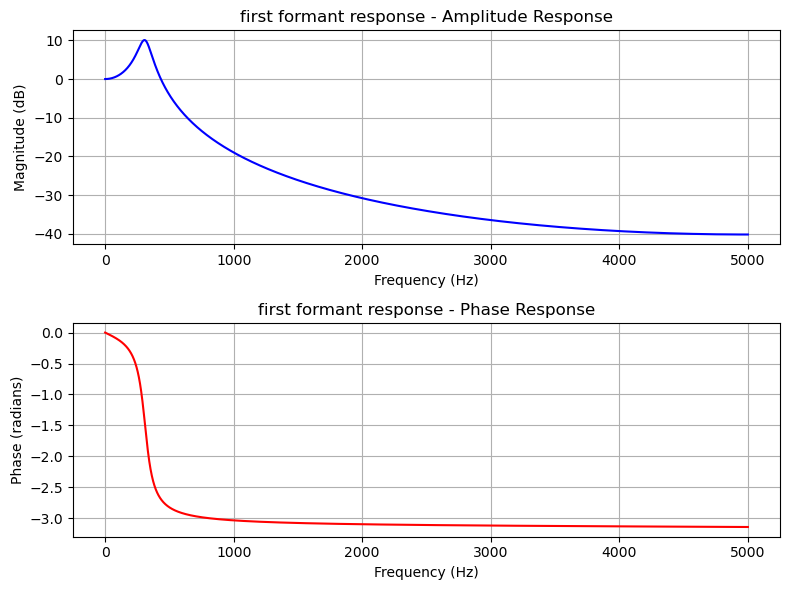

In [351]:
plot_response(first_H, fs, 'first formant response')

In [352]:
all_freqs = np.linspace(0, fs/2, 5000)

In [353]:
first_formant_amplitude = 20 * np.log10(np.abs(first_H))
print(first_formant_amplitude[center_frequency[0]])
single_rez_first_amplitude = first_formant_amplitude[center_frequency[0]]

10.048812699607883


In [354]:
second_rez, second_H = formant_resonator(signal, center_frequency[1], fs, BW[1])
second_cascade_rez, second_cascade_H = formant_resonator(first_rez, center_frequency[1], fs, BW[1])
print(np.array_equal(second_H, second_cascade_H))

True


In [355]:
second_formant_amplitude = 20 * np.log10(np.abs(second_H))
print(second_formant_amplitude[center_frequency[1]])
single_rez_second_amplitude = second_formant_amplitude[center_frequency[1]]

27.40069695208286


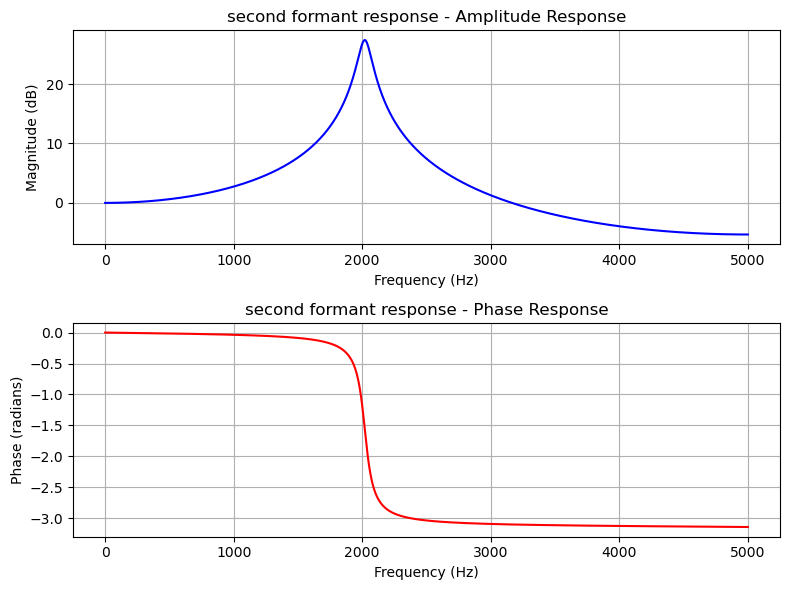

In [356]:
plot_response(second_H, fs, 'second formant response')

In [357]:
third_rez, third_H = formant_resonator(signal, center_frequency[2], fs, BW[2])
third_cascade_rez, third_cascade_H = formant_resonator(second_rez, center_frequency[2], fs, BW[2])
print(np.array_equal(second_H, second_cascade_H))

True


32.60483880249174


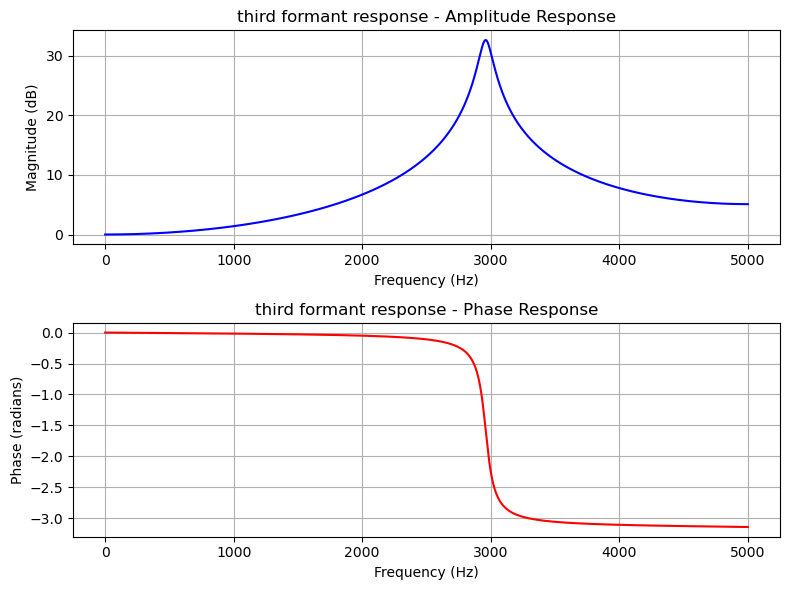

In [358]:
third_formant_amplitude = 20 * np.log10(np.abs(third_H))
print(third_formant_amplitude[center_frequency[2]])
single_rez_third_amplitude = third_formant_amplitude[center_frequency[2]]
plot_response(third_H, fs, 'third formant response')

In [359]:
fourth_rez, fourth_H = formant_resonator(signal, center_frequency[3], fs, BW[3])
fourth_cascade_rez, fourth_cascade_H = formant_resonator(third_rez, center_frequency[3], fs, BW[3])
print(np.array_equal(fourth_H, fourth_cascade_H))

True


38.1057181167527


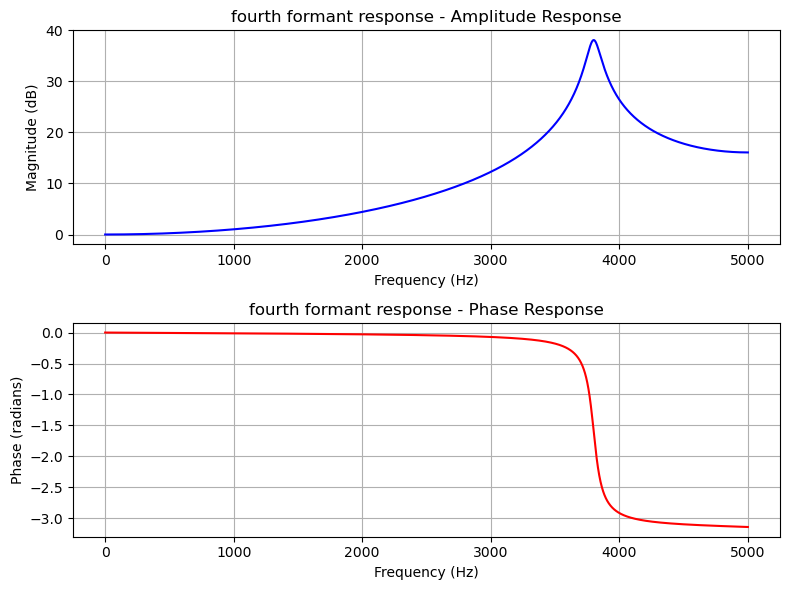

In [360]:
fourth_formant_amplitude = 20 * np.log10(np.abs(fourth_H))
print(fourth_formant_amplitude[center_frequency[3]])
single_rez_fourth_amplitude = fourth_formant_amplitude[center_frequency[3]]
plot_response(fourth_H, fs, 'fourth formant response')

In [361]:
fifth_rez, fifth_H = formant_resonator(signal, center_frequency[4], fs, BW[4])
fifth_cascade_rez, fifth_cascade_H = formant_resonator(fourth_rez, center_frequency[4], fs, BW[4])
print(np.array_equal(fifth_H, fifth_cascade_H))

True


54.03490920262154


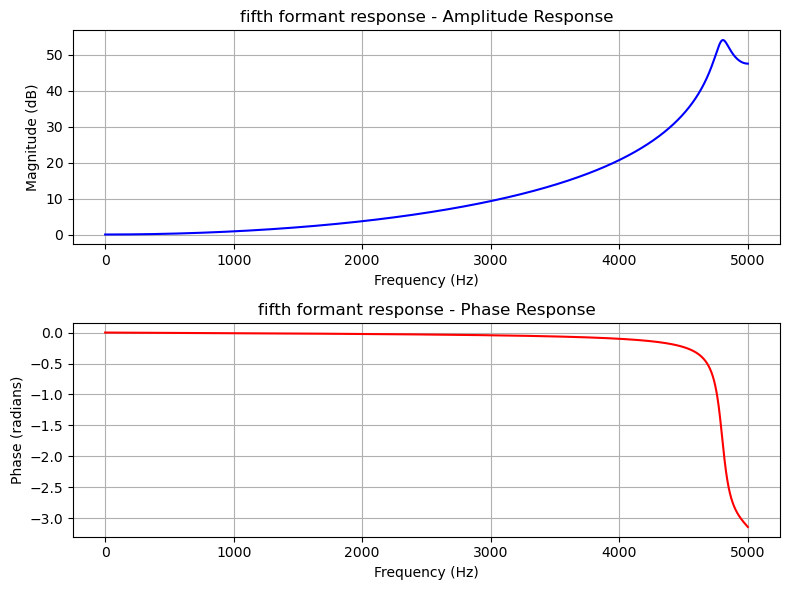

In [362]:
fifth_formant_amplitude = 20 * np.log10(np.abs(fifth_H))
print(fifth_formant_amplitude[center_frequency[4]])
single_rez_fifth_amplitude = fifth_formant_amplitude[center_frequency[4]]
plot_response(fifth_H, fs, 'fifth formant response')

In [363]:
cascade_H = first_H * second_H * third_H * fourth_H * fifth_H
cascade_output = fifth_cascade_rez

10.592473177226205 11.631739291063457 18.731652749784995 22.70209019637941 30.14065609993347


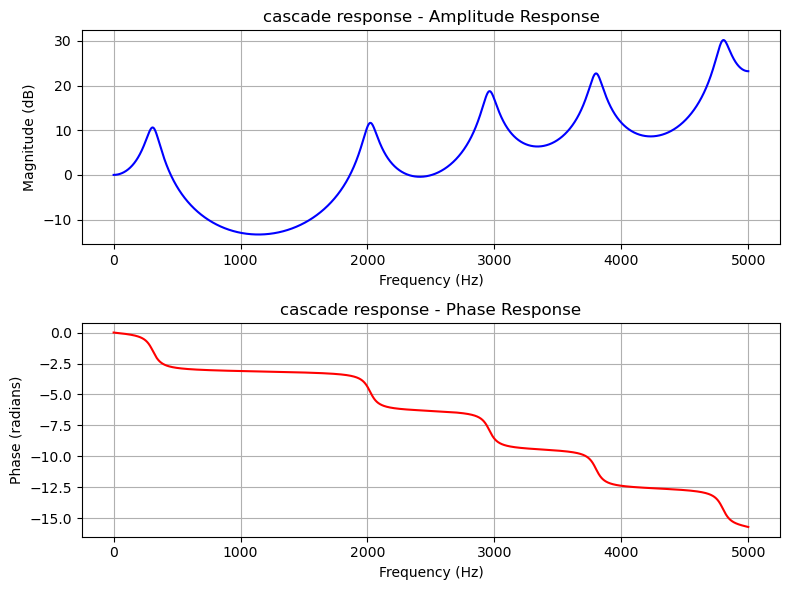

In [364]:
cascade_amplitude = 20 * np.log10(np.abs(cascade_H)) # in db
print(cascade_amplitude[center_frequency[0]], 
      cascade_amplitude[center_frequency[1]], 
      cascade_amplitude[center_frequency[2]], 
      cascade_amplitude[center_frequency[3]], 
      cascade_amplitude[center_frequency[4]]
      )
plot_response(cascade_H, fs, 'cascade response')

In [365]:
low_pass_out, lp_coeffs = low_pass_filter(signal, cutoff_frequency=500, sample_rate=fs)
formant_out, formant_coeffs = formant_resonator(signal, formant_frequency=500, sample_rate=fs, bandwidth=100)


In [366]:
sf.write(f"cascade_i_pure.wav", cascade_output, fs)

In [367]:
import scipy.signal as sig
A_lp, B_lp, _ = lp_coeffs
low_pass_total = low_pass_filter(cascade_output, cutoff_frequency=500, sample_rate=fs)

In [368]:
# sf.write(f"i_vowel.wav", low_pass_total, fs)

In [369]:
cascade_first_amplitude = cascade_amplitude[center_frequency[0]]
cascade_second_amplitude = cascade_amplitude[center_frequency[1]]
cascade_third_amplitude = cascade_amplitude[center_frequency[2]]

In [370]:
G1 = cascade_first_amplitude / single_rez_first_amplitude
G2 = cascade_second_amplitude / single_rez_second_amplitude
G3 = cascade_third_amplitude / single_rez_third_amplitude

In [371]:
print(G1, G2, G3)

1.0541019614824283 0.42450523471736995 0.5745053015981627


In [372]:
three_parallel_output = G1 * first_rez - G2 * second_rez + G3 * third_rez
three_parallel_H = G1 * first_H - G2 * second_H + G3 * third_H
# alternating the polarity

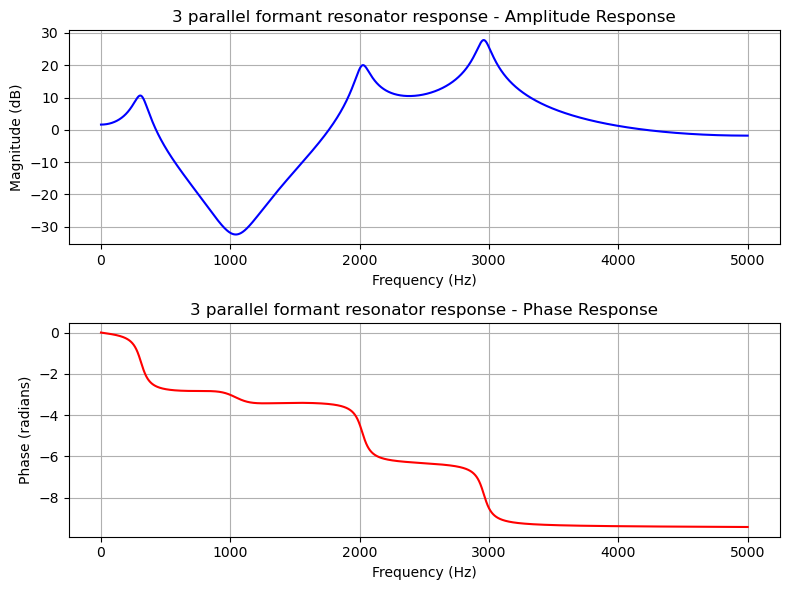

In [373]:
plot_response(three_parallel_H, fs, '3 parallel formant resonator response')

In [374]:
sf.write(f"parallel_i_vowel.wav", three_parallel_output, fs)

In [375]:
# --- Differentiator (f2 and f3) ---
# y[n] = (x[n] – x[n-1]) / T_s
def differentiator(signal, fs):
    T_s = 1 / fs
    y = np.zeros_like(signal)
    # For first sample, approximate as x[0]/T_s
    y[0] = signal[0] / T_s
    for n in range(1, len(signal)):
        y[n] = 1/T_s*signal[n] - 1/T_s*signal[n-1]
    # Transfer function: H(z)= (1 - z^(-1))/T_s, so numerator = [1, -1] and denominator = [T_s]
    return y, (1, -1, 0)

In [376]:
""" # first is a pre emphasis

y[n]=Apre​⋅(x[n]−Bpre​⋅x[n−1])

where Bpre=EXP(-2*PI()*f_pre*T_s), Apre=1-Bpre and f_pre=640

# Then a low-pass filter:

y[n]=ALP​⋅x[n]+BLP​⋅y[n−1]

where BLP=EXP(-2*PI()*f_allpass*T_s), ALP=1-BLP and f_allpass=270

# and then a final high-pass:

y[n]=ApreAll​​⋅(x[n]−BpreAll​⋅x[n−1])

where BpreAll=EXP(-2*PI()*(-f_allpass)*T_s) and ApreAll=1-BpreAll.

# each filter feeds into the next."""

' # first is a pre emphasis\n\ny[n]=Apre\u200b⋅(x[n]−Bpre\u200b⋅x[n−1])\n\nwhere Bpre=EXP(-2*PI()*f_pre*T_s), Apre=1-Bpre and f_pre=640\n\n# Then a low-pass filter:\n\ny[n]=ALP\u200b⋅x[n]+BLP\u200b⋅y[n−1]\n\nwhere BLP=EXP(-2*PI()*f_allpass*T_s), ALP=1-BLP and f_allpass=270\n\n# and then a final high-pass:\n\ny[n]=ApreAll\u200b\u200b⋅(x[n]−BpreAll\u200b⋅x[n−1])\n\nwhere BpreAll=EXP(-2*PI()*(-f_allpass)*T_s) and ApreAll=1-BpreAll.\n\n# Each filter feeds into the next.'

In [377]:
diff_f2, diff_second_H = differentiator(second_rez, fs)
diff_f3, diff_third_H = differentiator(third_rez, fs)

In [378]:
diff_par_output = G1 * first_rez - G2 * diff_f2 + G3 * diff_f3
diff_par_H = G1 * first_H - G2 * second_H + G3 * third_H
# alternating the polarity

In [379]:
def plot_response_overlay(H, sample_rate, label):
    f = np.linspace(0, sample_rate/2, len(H))
    amplitude = 20 * np.log10(np.abs(H))
    phase = np.unwrap(np.angle(H))

    # Plot amplitude
    plt.subplot(2, 1, 1)
    plt.plot(f, amplitude, label=label)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude (dB)")
    plt.grid(True)

    # Plot phase
    plt.subplot(2, 1, 2)
    plt.plot(f, phase, label=label)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Phase (radians)")
    plt.grid(True)


In [380]:
def plot_multiple_responses(H_list, sample_rate, labels):
    plt.figure(figsize=(8, 6))
    
    for H, label in zip(H_list, labels):
        plot_response_overlay(H, sample_rate, label)
    
    plt.subplot(2, 1, 1)
    plt.title("Amplitude Response")
    plt.legend()
    
    plt.subplot(2, 1, 2)
    plt.title("Phase Response")
    plt.legend()
    
    plt.tight_layout()
    plt.show()


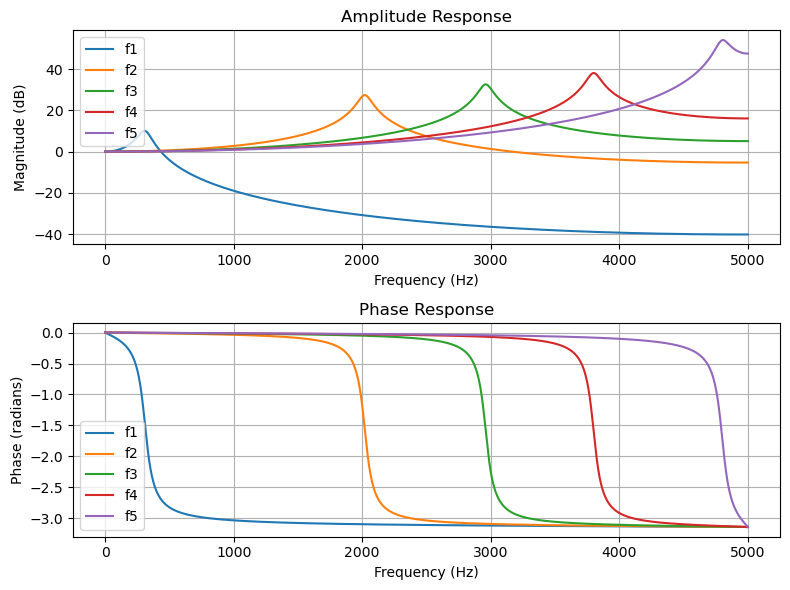

In [381]:
plot_multiple_responses([first_H, second_H, third_H, fourth_H, fifth_H], fs, ['f1', 'f2', 'f3', 'f4', 'f5'])


In [382]:
def plot_lowpass_response(A, B, sample_rate, label):
    T_s = 1 / sample_rate
    f = np.linspace(0, sample_rate/2, 1024)
    theta = 2 * np.pi * f * T_s
    # Low-pass: H(f) = A / (1 - B exp(-j*theta))
    H = A / (1 - B * np.exp(-1j * theta))
    amplitude = 20 * np.log10(np.abs(H))
    phase = np.unwrap(np.angle(H))

    plt.figure(figsize=(8,6))
    plt.subplot(2,1,1)
    plt.plot(f, amplitude, 'b')
    plt.title(f"{label} - Amplitude Response")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude (dB)")
    plt.grid(True)
    plt.subplot(2,1,2)
    plt.plot(f, phase, 'r')
    plt.title(f"{label} - Phase Response")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Phase (radians)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

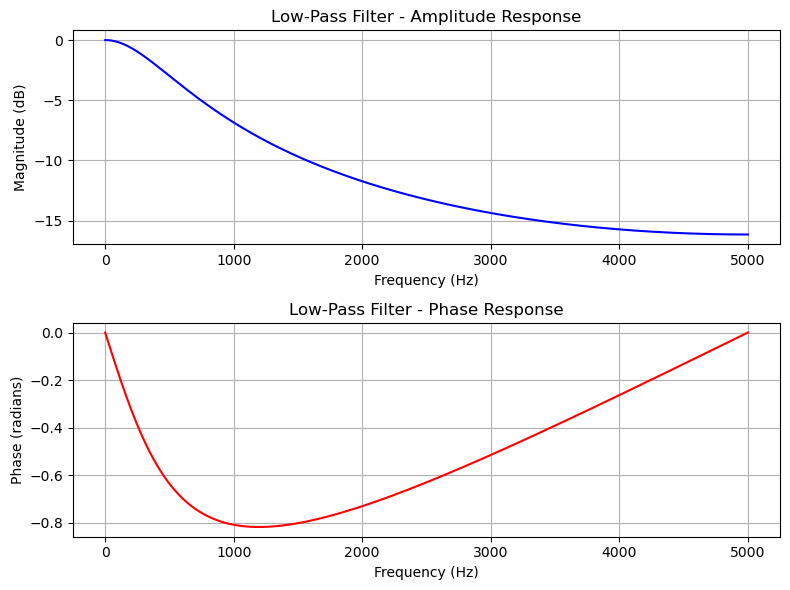

In [383]:
A_lp, B_lp, _ = lp_coeffs
plot_lowpass_response(A_lp, B_lp, fs, "Low-Pass Filter")

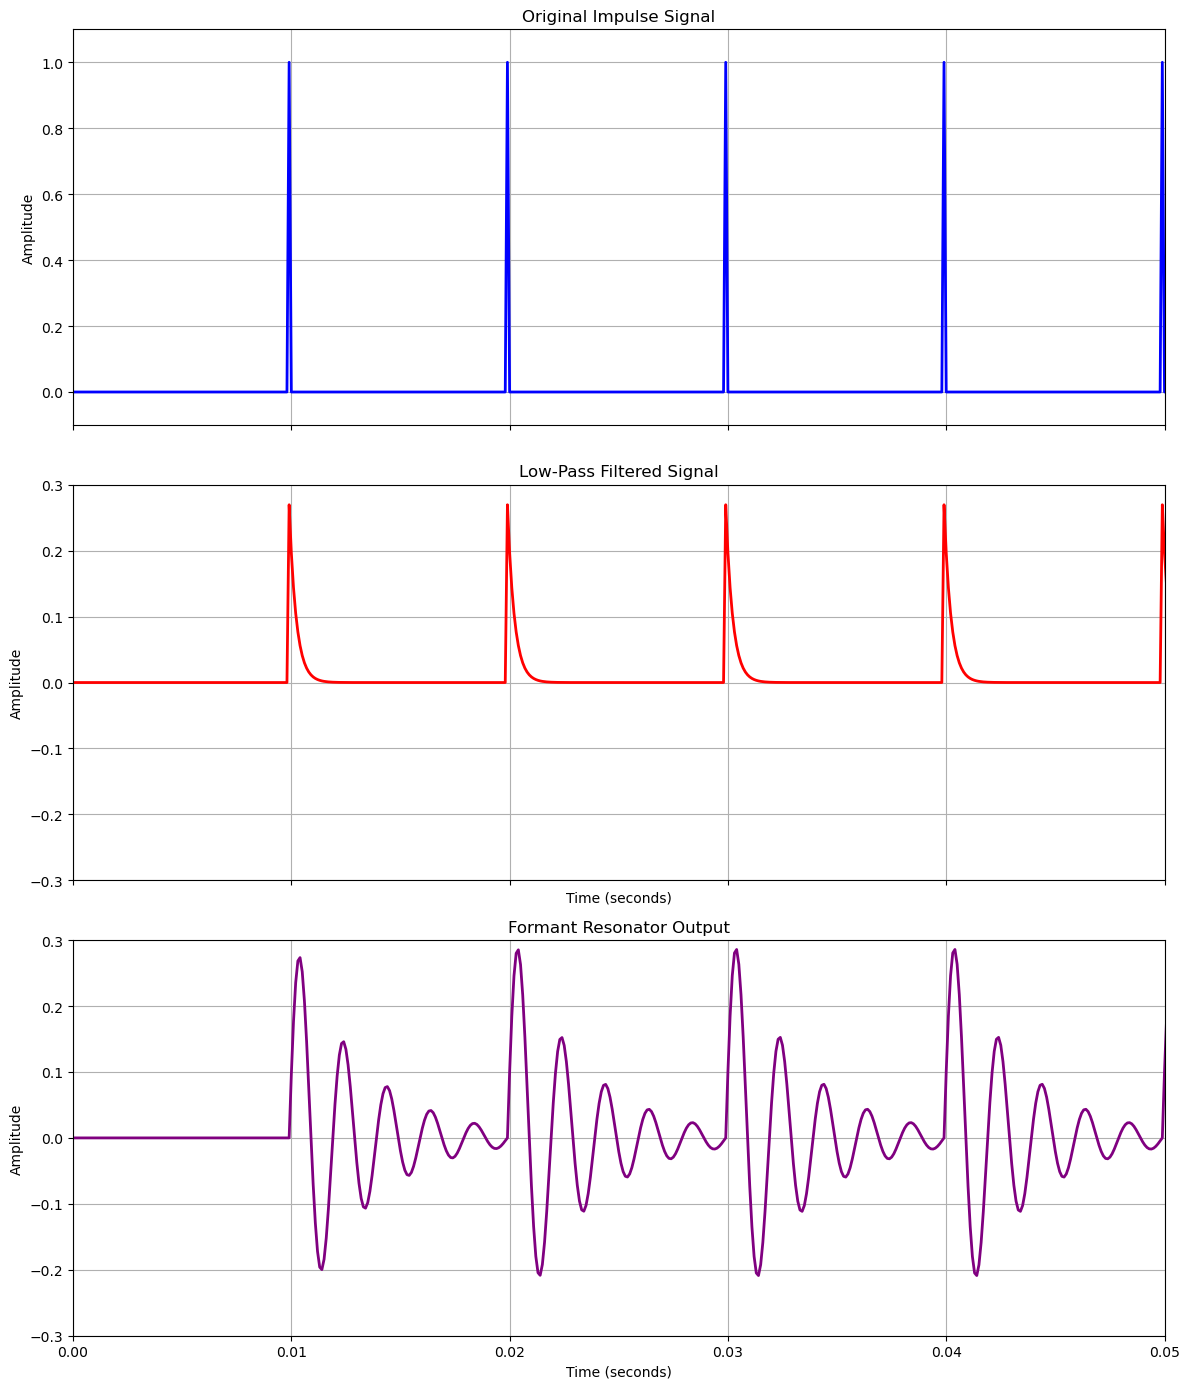

In [384]:
# add plots for: [time domain]
# original signal
# formant resonator output
# low pass filter output

t = np.linspace(0, length_seconds, int(fs * length_seconds), endpoint=False)

# Create separate subplots
fig, axs = plt.subplots(3, 1, figsize=(12, 14), sharex=True)

# Plot the original impulse signal
axs[0].plot(t, signal, color="blue", linewidth=2)
axs[0].set_title("Original Impulse Signal")
axs[0].set_ylabel("Amplitude")
axs[0].grid()
axs[0].set_xlim(0, 0.05)  # zoom in to the first 0.05 seconds
axs[0].set_ylim(-0.10, 1.1)  # zoom in 

# Plot the filtered signal
axs[1].plot(t, low_pass_out, color="red", linewidth=2)
axs[1].set_title("Low-Pass Filtered Signal")
axs[1].set_xlabel("Time (seconds)")
axs[1].set_ylabel("Amplitude")
axs[1].grid()
axs[1].set_xlim(0, 0.05)  # zoom in to the first 0.05 seconds
axs[1].set_ylim(-0.30, 0.30)  # zoom in

# Plot the formant resonator output signal
axs[2].plot(t, formant_out, color="purple", linewidth=2)
axs[2].set_title("Formant Resonator Output")
axs[2].set_xlabel("Time (seconds)")
axs[2].set_ylabel("Amplitude")
axs[2].grid()
axs[2].set_xlim(0, 0.05)  # zoom in to the first 0.05 seconds
axs[2].set_ylim(-0.30, 0.30)  # zoom in


# Adjust layout and show the plots
plt.tight_layout()
plt.show()

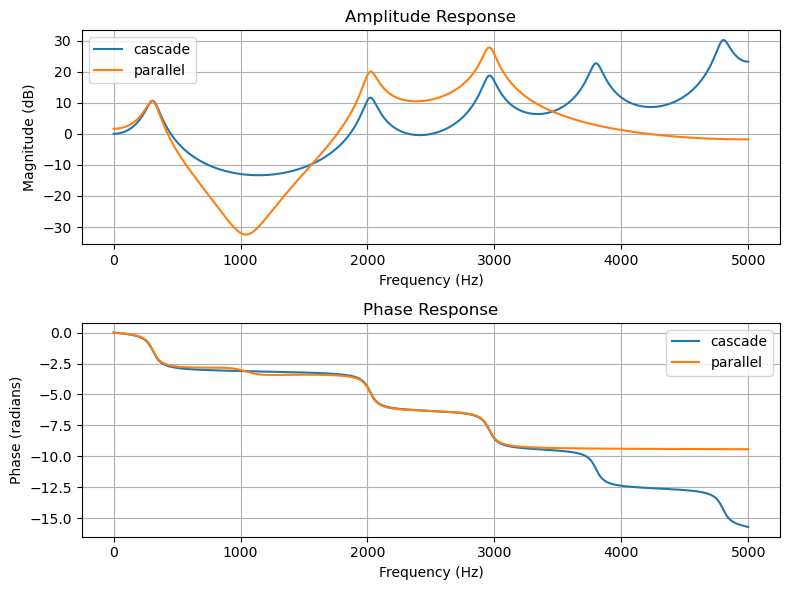

In [385]:
plot_multiple_responses([cascade_H, three_parallel_H], fs, ['cascade', 'parallel'])